# Regression using a Neural Network (Pytorch)
The data is in 'housing.csv'. <br>
Each row in the table is a data point:  the features of an area in California <br>
Clearly, the `median_house_value` is correlated with some other features, e.g., `median_income` and location <br>
Thus, we can estimate `median_house_value` = regression_model(`median_income`, `longitude`, `latitude`, ...) <br>
The taks is to build an MLP regressor to predict `median_house_value` using the other features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.shape

(20640, 10)

### Data pre-processing: remove NaN

In [4]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
# there are 207 NaN in the column 'total_bedrooms', remove them
# check housing again using housing.isnull().sum()
housing['total_bedrooms'].fillna((housing['total_bedrooms'].mean()), inplace=True)
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### Data pre-processing: Convert categorical data to numerical data - "ocean_proximity"

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
#We can use one-hot encoding method by calling pd.get_dummies
categorical_columns=['ocean_proximity'] # must be a list
housing = pd.get_dummies(housing, columns=categorical_columns)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


### Visualize the data

Text(0.5, 1.0, 'median_income')

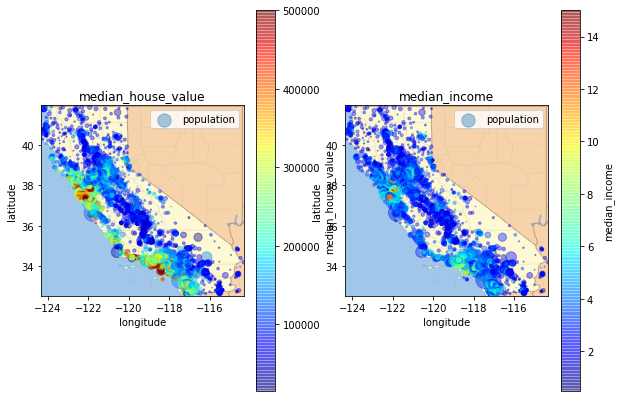

In [8]:
from skimage.io import imread
california_img = imread('california.png')
x1 = min(housing["longitude"].values)
x2 = max(housing["longitude"].values)
y1 = min(housing["latitude"].values)
y2 = max(housing["latitude"].values)
#---------------------------------------------
# the parameter c refers to color
# thus, median_house_value is color-coded in the left plot
fig, ax =plt.subplots(1,2)
housing.plot(ax=ax[0], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
#---------------------------------------------
# the parameter c refers to color
# thus, median_income is color-coded in the right plot
ax[0].imshow(california_img,extent=[x1,x2,y1,y2])
ax[0].set_title('median_house_value')
housing.plot(ax=ax[1], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_income", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
ax[1].imshow(california_img,extent=[x1,x2,y1,y2])
ax[1].set_title('median_income')

### Prepare the Training and Testing Datasets

In [9]:
X=housing.drop(['median_house_value'], axis=1)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0


In [10]:
Y=housing['median_house_value']
Y.head()

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64

In [11]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X_columns=X.columns #store the column names
X=X.values.astype('float32')
Y=Y.values.astype('float32')

### trainnig, validation, testing split

In [12]:
#trainnig, validation, testing split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (14860, 13) (14860,)
validation: (1652, 13) (1652,)
test: (4128, 13) (4128,)


In [13]:
#apply feature normalization to training, validation and test sets
from sklearn.preprocessing import MinMaxScaler
scalerX=MinMaxScaler()
scalerX.fit(X_train) # think about why fit to X_train, not X ?
X_train=scalerX.transform(X_train)
X_val=scalerX.transform(X_val)
X_test=scalerX.transform(X_test)

In [14]:
X_train[0]

array([0.5786848 , 0.38044596, 0.19607843, 0.12570114, 0.13671634,
       0.00983827, 0.02795593, 0.11055019, 0.        , 1.        ,
       0.        , 0.        , 0.        ], dtype=float32)

In [15]:
#normalize the output to facilitate convergence
Y_train_max=Y_train.max()
Y_train/=Y_train_max
Y_val/=Y_train_max
Y_test/=Y_train_max

### use LinearRegression as the baseline model

In [16]:
#step1:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept=True)

In [17]:
#step2:
linear_model.fit(X_train, Y_train)

LinearRegression()

In [18]:
linear_model.coef_

array([-0.52667564, -0.47057658,  0.11070046, -0.31356594,  0.8725233 ,
       -2.8026845 ,  1.0090173 ,  1.1304911 , -0.04725012, -0.12498051,
        0.26538336, -0.05612987, -0.03702499], dtype=float32)

In [19]:
linear_model.intercept_

0.54965425

Evaluate model on testing set
MSE= 0.018863907
MAE= 0.09931183
MAPE= 0.28951442


Text(0, 0.5, 'Y_test_pred')

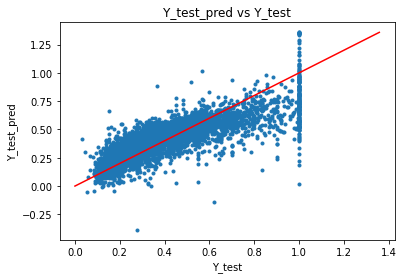

In [20]:
#step3:
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)
#step6: 
# the red line is the 45-degree line
fig, ax = plt.subplots()
ax.set_title('Y_test_pred vs Y_test')
ax.plot(Y_test, Y_test_pred, '.')
ymax=np.max([Y_test.max(), Y_test_pred.max()])
ax.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')

## Your work begins here
see NN_nonlinear_regression_Pytorch.ipynb

#### define a dataset to hold/represent the data

In [21]:
#I give you the code here, because it is tricky
import torch
from torch.utils.data import Dataset as torch_dataset
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y.reshape(-1, 1) #this is very important
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        # use the notation DatasetName[idx]
        # to get a data point (x,y) by idx
        # we need to convert numpy array to torch tensor
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.float32)
        return x, y

Create instance objects of the `MyDataset` class <br>
a training dataset `dataset_train` <br>
a validation dataset `dataset_val` <br>
a testing dataset `dataset_test` <br>

In [22]:
dataset_train = MyDataset(X_train, Y_train)
dataset_val = MyDataset(X_val, Y_val)
dataset_test = MyDataset(X_test, Y_test)

In [23]:
len(dataset_train) # get the number of data points in the training set

14860

create dataloaders which will be used to generate minibatches <br>
batch_size=N means each minibatch contains N data points  <br>
note: the last minibatch may contain less than N data points

In [24]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size= 128, shuffle= True, drop_last= False)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size= 128, shuffle= False, drop_last= False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size= 128, shuffle= False, drop_last= False)

In [25]:
len(dataloader_train) # get the number of minibatches

117

In [26]:
#verify the shape of each tensor in a batch
for batch_idx, (X, Y) in enumerate(dataloader_train):
    print(batch_idx, X.size(), Y.size())

0 torch.Size([128, 13]) torch.Size([128, 1])
1 torch.Size([128, 13]) torch.Size([128, 1])
2 torch.Size([128, 13]) torch.Size([128, 1])
3 torch.Size([128, 13]) torch.Size([128, 1])
4 torch.Size([128, 13]) torch.Size([128, 1])
5 torch.Size([128, 13]) torch.Size([128, 1])
6 torch.Size([128, 13]) torch.Size([128, 1])
7 torch.Size([128, 13]) torch.Size([128, 1])
8 torch.Size([128, 13]) torch.Size([128, 1])
9 torch.Size([128, 13]) torch.Size([128, 1])
10 torch.Size([128, 13]) torch.Size([128, 1])
11 torch.Size([128, 13]) torch.Size([128, 1])
12 torch.Size([128, 13]) torch.Size([128, 1])
13 torch.Size([128, 13]) torch.Size([128, 1])
14 torch.Size([128, 13]) torch.Size([128, 1])
15 torch.Size([128, 13]) torch.Size([128, 1])
16 torch.Size([128, 13]) torch.Size([128, 1])
17 torch.Size([128, 13]) torch.Size([128, 1])
18 torch.Size([128, 13]) torch.Size([128, 1])
19 torch.Size([128, 13]) torch.Size([128, 1])
20 torch.Size([128, 13]) torch.Size([128, 1])
21 torch.Size([128, 13]) torch.Size([128, 1]

#### Now, let's build a neural network that has many hidden layers and nonlinear activation - softplus

In [27]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, n_units):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_units)
        self.layer2 = nn.Linear(n_units, n_units)
        self.layer3 = nn.Linear(n_units, output_dim)      
        
    def forward(self,x):
        x = self.layer1(x)
        x = F.softplus(x)
        x = self.layer2(x)
        x = F.softplus(x)
        x = self.layer3(x)
        return x

create an instance object of the class

In [28]:
net = Net(input_dim=13, output_dim=1, n_units=128)

In [29]:
#move the model to GPU if you have a GPU

if torch.cuda.is_available():
    net = net.cuda()
print(net)

Net(
  (layer1): Linear(in_features=13, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=1, bias=True)
)


define a function to train the neural network in one epoch

In [30]:
def train(model, dataloader, optimizer, criterion, epoch):
    model.train()
    loss_train = 0
    for batch_index, (data,label) in enumerate(dataloader):
        if torch.cuda.is_available():
            data,label = data.cuda(), label.cuda()
            
        optimizer.zero_grad() # set grad 0 for each grad update
        y_pred = model.forward(data)
        loss = criterion(y_pred,label)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
        if batch_index % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_index * data.size(0), len(dataloader.dataset),
                    100. * batch_index / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    return loss_train

define a function to evaluate the neural network on the validation set or the testing set

In [31]:
def test(model, dataloader, criterion):
    model.eval()
    loss_test = 0
    sample_count = 0

    with torch.no_grad():
        for batch_index, (data,label) in enumerate(dataloader):   
            if torch.cuda.is_available():
                data,label = data.cuda(), label.cuda()
            y_pred = model.forward(data)
            loss = criterion(y_pred,label)
            loss_test += loss.item()
            
        
    loss_test /= len(dataloader)
    return loss_test

create an optimizer (e.g. Adam) and send the parameters of the model to the optimizer

In [32]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

train the neural network model for many epochs <br>
It may need 100 epochs to converge.
So, we will not save any model to harddrive 

In [33]:
criterion = nn.MSELoss()
loss_train_list=[]
loss_val_list=[]
epochSize = 100

In [34]:
for epoch in range(epochSize):
    loss_train = train(net, dataloader_train, optimizer, criterion, epoch)
    loss_train_list.append(loss_train)
    print('epoch', epoch, 'training loss:', loss_train)
    
    loss_val = test(net, dataloader_val, criterion)
    loss_val_list.append(loss_val)
    print('epoch', epoch, 'validation loss:', loss_val)

Train Epoch: 0 [0/14860 (0%)]	Loss: 0.914888
Train Epoch: 0 [12800/14860 (85%)]	Loss: 0.055085
epoch 0 training loss: 0.10703626817140059
epoch 0 validation loss: 0.048031167628673405
Train Epoch: 1 [0/14860 (0%)]	Loss: 0.052762
Train Epoch: 1 [12800/14860 (85%)]	Loss: 0.042997
epoch 1 training loss: 0.04252217460073467
epoch 1 validation loss: 0.03914599378521626
Train Epoch: 2 [0/14860 (0%)]	Loss: 0.042982
Train Epoch: 2 [12800/14860 (85%)]	Loss: 0.034738
epoch 2 training loss: 0.039488416149193406
epoch 2 validation loss: 0.043028684762807995
Train Epoch: 3 [0/14860 (0%)]	Loss: 0.043674
Train Epoch: 3 [12800/14860 (85%)]	Loss: 0.028668
epoch 3 training loss: 0.037742376852876104
epoch 3 validation loss: 0.0342632715518658
Train Epoch: 4 [0/14860 (0%)]	Loss: 0.034715
Train Epoch: 4 [12800/14860 (85%)]	Loss: 0.038413
epoch 4 training loss: 0.033330532746055186
epoch 4 validation loss: 0.03160451008723332
Train Epoch: 5 [0/14860 (0%)]	Loss: 0.027617
Train Epoch: 5 [12800/14860 (85%)]	L

plot the loss vs epoch curve

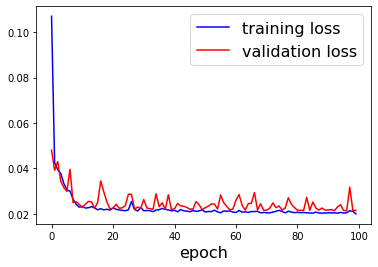

In [37]:
import matplotlib.pyplot as plt
epoch = range(0,epochSize)
fig, ax = plt.subplots()
ax.plot(epoch, loss_train_list, 'b', label = 'training loss')
ax.plot(epoch, loss_val_list,   'r', label = 'validation loss')
ax.set_xlabel('epoch', fontsize = 16)
ax.legend(fontsize=16)

In [39]:
# obtain Yp_test
# "Yp_test=model(X_test)"  may need lots of memory
# we can use a for loop to get Yp_test, see the function test
Yp_test=[]
net.eval()
with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
     for batch_idx, (X, Y) in enumerate(dataloader_test):
         if torch.cuda.is_available():
             X = X.cuda()
         Yp = net.forward(X)#forward pass
         Yp_test.append(Yp.detach().cpu().numpy())        
Yp_test=np.concatenate(Yp_test, axis=0).squeeze()

In [40]:
# compute MSE, MAE and MAPE on test set
import numpy as np
MSE = np.mean((Y_test - Yp_test)**2)
MAE = np.mean(np.abs(Y_test - Yp_test))
MAPE =  np.mean(np.abs(Y_test - Yp_test)/Y_test)
print('Evaluate model on testing set')
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)

Evaluate model on testing set
MSE= 0.020257961
MAE= 0.10561602
MAPE= 0.31419522


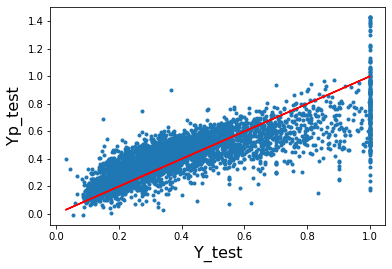

In [41]:
# plot Yp_test vs Y_test
# the red line is the 45-degree line
fig, ax = plt.subplots()
ax.plot(Y_test, Yp_test, '.')
ax.plot(Y_test, Y_test, 'r-')
ax.set_xlabel('Y_test', fontsize=16)
ax.set_ylabel('Yp_test', fontsize=16)
ax.grid(False)

### change the structure of the MLP model and see if it can do better than XGBoost

[07:14:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:14:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0.5, 1.0, 'MSE=0.008540076, MAE=0.060400516, MAPE=0.17073536')

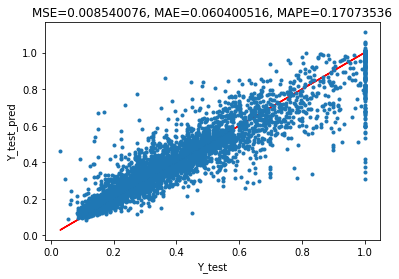

In [43]:
#define a new model
#train, validate and test the model
#compare it with XGBoost in homework #3

from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor

def my_scorer(model, X, y):
    y_pred = model.predict(X)
    #MSE = np.mean((y_pred - y)**2)
    #MAE = np.mean(np.abs(y_pred - y))
    MAPE =  np.mean(np.abs(y_pred - y)/y)
    return MAPE

depth_list=np.array([1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
parameters = {'max_depth':depth_list}
GSC = GridSearchCV(XGBRegressor(), parameters, cv=10, scoring=my_scorer, n_jobs=4)
GSC.fit(X_train, Y_train)
MAPE_mean=GSC.cv_results_['mean_test_score']
max_depth_best = depth_list[np.argmin(MAPE_mean)]
# build a XGBRegressor using the best hyperparameter and fit it to the training data
xgb_model=XGBRegressor(max_depth=max_depth_best)
xgb_model.fit(X_train, Y_train)
Y_train_pred = xgb_model.predict(X_train)
Y_test_pred = xgb_model.predict(X_test)

MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE = np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#

plt.plot(Y_test,Y_test, '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
#plt.axis([0, 1e6, 0, 1e6])

NewNet(
  (layer1): Linear(in_features=13, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=1, bias=True)
)
Train Epoch: 0 [0/14860 (0%)]	Loss: 0.109761
Train Epoch: 0 [12800/14860 (85%)]	Loss: 0.048891
epoch 0 training loss: 0.059182703924866825
epoch 0 validation loss: 0.05369031715851564
Train Epoch: 1 [0/14860 (0%)]	Loss: 0.057764
Train Epoch: 1 [12800/14860 (85%)]	Loss: 0.043553
epoch 1 training loss: 0.05531301540442002
epoch 1 validation loss: 0.053159973942316495
Train Epoch: 2 [0/14860 (0%)]	Loss: 0.044272
Train Epoch: 2 [12800/14860 (85%)]	Loss: 0.050496
epoch 2 training loss: 0.05402708599646377
epoch 2 validation loss: 0.05285917709653194
Train Epoch: 3 [0/14860 (0%)]	Loss: 0.051184
Train Epoch: 3 [12800/14860 (85%)]	Loss: 0.049457
epoch 3 training loss: 0.0

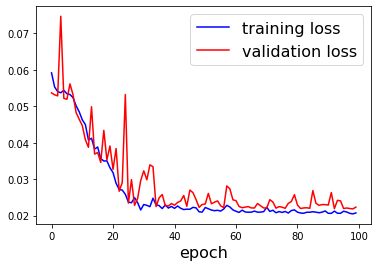

In [44]:

import torch.nn as nn
import torch.nn.functional as F
class NewNet(nn.Module):
    def __init__(self):
        super(NewNet,self).__init__()
        self.layer1 = nn.Linear(13, 64)        
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, 64) 
        self.layer5 = nn.Linear(64, 1)
        
    def forward(self,x):
        x = self.layer1(x)
        x = F.softplus(x)
        x = self.layer2(x)
        x = F.softplus(x)
        x = self.layer3(x)
        x = F.softplus(x)
        x = self.layer4(x)
        x = F.softplus(x)
        x = self.layer5(x)
        return x


newnet = NewNet()
optimizer = torch.optim.SGD(newnet.parameters(), lr=0.01, momentum=0.9)
if torch.cuda.is_available():
    newnet = newnet.cuda()
print(newnet)


criterion = nn.MSELoss()
loss_train_list=[]
loss_val_list=[]
epochSize = 100

for epoch in range(epochSize):
    loss_train = train(newnet, dataloader_train, optimizer, criterion, epoch)
    loss_train_list.append(loss_train)
    print('epoch', epoch, 'training loss:', loss_train)
    
    loss_val = test(newnet, dataloader_val, criterion)
    loss_val_list.append(loss_val)
    print('epoch', epoch, 'validation loss:', loss_val)

import matplotlib.pyplot as plt
epoch = range(0,epochSize)
fig, ax = plt.subplots()
ax.plot(epoch, loss_train_list, 'b', label = 'training loss')
ax.plot(epoch, loss_val_list,   'r', label = 'validation loss')
ax.set_xlabel('epoch', fontsize = 16)
ax.legend(fontsize=16)

Yp_test=[]
newnet.eval()
with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
    for batch_idx, (X, Y) in enumerate(dataloader_test):
        if torch.cuda.is_available():
            X = X.cuda()
        Yp = newnet.forward(X)#forward pass
        Yp_test.append(Yp.detach().cpu().numpy())        
Yp_test=np.concatenate(Yp_test, axis=0).squeeze()



MSE= 0.021196023
MAE= 0.110505864
MAPE= 0.33792174


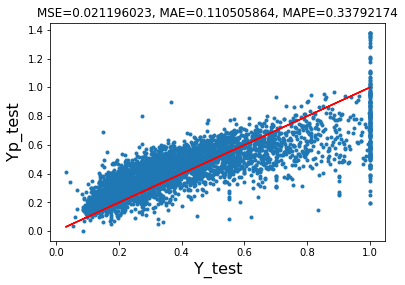

In [46]:
# compute MSE, MAE and MAPE on test set
import numpy as np
MSE = np.mean((Y_test - Yp_test)**2)
MAE = np.mean(np.abs(Y_test - Yp_test))
MAPE =  np.mean(np.abs(Y_test - Yp_test)/Y_test)

print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)


# plot Yp_test vs Y_test
# the red line is the 45-degree line
fig, ax = plt.subplots()
ax.plot(Y_test, Yp_test, '.')
ax.plot(Y_test, Y_test, 'r-')
ax.set_xlabel('Y_test', fontsize=16)
ax.set_ylabel('Yp_test', fontsize=16)
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
ax.grid(False)